In [240]:
import pymysql
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [606]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

In [666]:
# matplotlib 한글 출력..
import matplotlib as mpl
import matplotlib.font_manager as fm

mpl.rcParams['axes.unicode_minus'] = False
path = 'C:/Windows/Fonts/malgun.ttf'  # 내가 원하는 폰트로 따로 설정이 가능
font_name = fm.FontProperties(fname=path, size=50).get_name()
plt.rc('font', family=font_name)

# 데이터 전처리

In [356]:
# MySQL Connection 연결
conn = pymysql.connect(host='49.247.132.235', user='kbo_db', password='1234', db='kbo_data_db', charset='utf8')
# Connection 으로부터 Cursor 생성
curs = conn.cursor()

df_mvp = pd.read_excel('mvp_list.xlsx', index_col=0)
df_team_rank = pd.read_excel('team_win.xlsx', index_col=0)

for i in range(2010, 2020):
    df_mvp_f = df_mvp.loc[i]    
    sql = '''SELECT * from kbo_pitcher_total_status, kbo_pitcher_player
    WHERE kbo_pitcher_player.play_id = kbo_pitcher_total_status.player_id
    and player_year = {};''' .format(i)        
    curs.execute(sql)

    
    # 데이타 Fetch
    rows = curs.fetchall()

    df_1 = pd.DataFrame(rows)
    df_1 = df_1.drop([0,1,21], axis=1)

    team_year_rank = df_team_rank[df_team_rank[0] == i]

    df_1[2] = df_1[2].apply(lambda x: team_year_rank[1][x == team_year_rank[2]].values[0])
    df_1[13] = df_1[13].apply(lambda x: x.replace(' ',''))
    df_1[13] = df_1[13].apply(lambda x: x.replace('1/3', '.3') if('1/3' in x) else (x.replace('2/3', '.6') if('2/3' in x) else x))
    df_1 = df_1.apply(lambda x: x.replace('-','0'))    
    if df_mvp_f[2] == '투수':        
        df_1[23] = df_1[22].apply(lambda x: 1 if (df_mvp_f[0] == x) else 0)
    else:
        df_1[23] = 0
    df_1.to_excel('{}_투수.xlsx'.format(i))
        
    sql = '''SELECT * from kbo_hitter_total_status, kbo_hitter_player
    WHERE kbo_hitter_player.play_id = kbo_hitter_total_status.player_id
    and player_year = {};''' .format(i)        
    curs.execute(sql)

    
    # 데이타 Fetch
    rows = curs.fetchall()

    df_1 = pd.DataFrame(rows)
    df_1 = df_1.drop([0,1,23], axis=1)

    team_year_rank = df_team_rank[df_team_rank[0] == i]

    df_1[2] = df_1[2].apply(lambda x: team_year_rank[1][x == team_year_rank[2]].values[0])
    df_1[25] = df_1[24].apply(lambda x: 1 if (df_mvp_f[0] == x) else 0)
    df_1 = df_1.apply(lambda x: x.replace('-','0'))
    if df_mvp_f[2] != '투수':            
        df_1[25] = df_1[24].apply(lambda x: 1 if (df_mvp_f[0] == x) else 0)
    else:
        df_1[25] = 0
    
    df_1.to_excel('{}_타자.xlsx'.format(i))
# Connection 닫기
conn.close()

# 머신러닝

## 머신러닝 - 타자

,24,26
56,김태균,0.09
25,류지혁,0.08
2,이종환,0.05
12,김동한,0.03
145,홍명찬,0.03


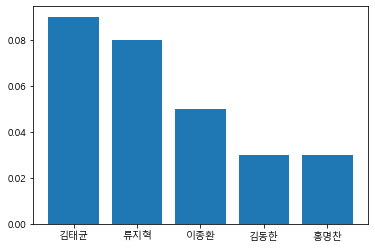

In [620]:
df_2010_hit = pd.read_excel('2010_타자.xlsx', index_col=0)
df_2012_hit = pd.read_excel('2012_타자.xlsx', index_col=0)

y = df_2010_hit[25]
x = df_2010_hit.drop([24,25], axis=1)
y1 = df_2012_hit[25]
x1 = df_2012_hit.drop([24,25], axis=1)

trr = RandomForestClassifier().fit(x, y)
preds = trr.predict_proba(x1)
list1 = preds[:,1]

df_2012_hit_c = df_2012_hit.copy()
df_2012_hit_c[26] = list1
df_2012_hit_c2 = df_2012_hit_c[[24,26]].sort_values(26, ascending=False)[:5]#.plot(kind='bar')
plt.bar(df_2012_hit_c2[24], df_2012_hit_c2[26], data = df_2013_hit_c2)
df_2012_hit_c2

,24,26
131,박병호,0.40
89,최형우,0.17
175,손아섭,0.08
143,최정,0.01
149,김현수,0.01


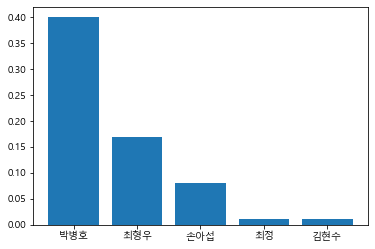

In [369]:
df_1012_hit = pd.concat([df_2010_hit, df_2012_hit])
df_2013_hit = pd.read_excel('2013_타자.xlsx', index_col=0)

y = df_1012_hit[25]
x = df_1012_hit.drop([24,25], axis=1)
y1 = df_2013_hit[25]
x1 = df_2013_hit.drop([24,25], axis=1)

trr = RandomForestClassifier().fit(x, y)
preds = trr.predict_proba(x1)
list1 = preds[:,1]

df_2013_hit_c = df_2013_hit.copy()
df_2013_hit_c[26] = list1
df_2013_hit_c2 = df_2013_hit_c[[24,26]].sort_values(26, ascending=False)[:5]#.plot(kind='bar')
plt.bar(df_2013_hit_c2[24], df_2013_hit_c2[26], data = df_2013_hit_c2)
df_2013_hit_c2

,24,26
137,박병호,0.68
154,강정호,0.63
69,테임즈,0.58
180,서건창,0.37
55,나바로,0.37


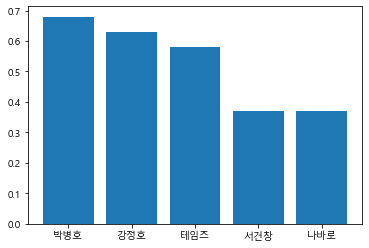

In [390]:
df_101213_hit = pd.concat([df_1012_hit, df_2013_hit])
# 서건창 역대기록 달성 (예외)
df_2014_hit = pd.read_excel('2014_타자.xlsx', index_col=0)

y = df_101213_hit[25]
x = df_101213_hit.drop([24,25], axis=1)
y1 = df_2014_hit[25]
x1 = df_2014_hit.drop([24,25], axis=1)

trr = RandomForestClassifier().fit(x, y)
preds = trr.predict_proba(x1)
list1 = preds[:,1]

df_2014_hit_c = df_2014_hit.copy()
df_2014_hit_c[26] = list1
df_2014_hit_c2 = df_2014_hit_c[[24,26]].sort_values(26, ascending=False)[:5]#.plot(kind='bar')
plt.bar(df_2014_hit_c2[24], df_2014_hit_c2[26], data = df_2014_hit_c2)
df_2014_hit_c2

,24,26
91,테임즈,0.68
177,박병호,0.64
75,나바로,0.58
141,최형우,0.44
166,유한준,0.43


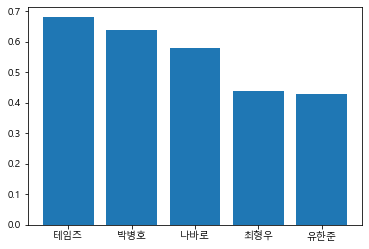

In [427]:
df_10121314_hit = pd.concat([df_101213_hit, df_2014_hit])
df_2015_hit = pd.read_excel('2015_타자.xlsx', index_col=0)

y = df_10121314_hit[25]
x = df_10121314_hit.drop([24,25], axis=1)
y1 = df_2015_hit[25]
x1 = df_2015_hit.drop([24,25], axis=1)

trr = RandomForestClassifier().fit(x, y)
preds = trr.predict_proba(x1)
list1 = preds[:,1]

df_2015_hit_c = df_2015_hit.copy()
df_2015_hit_c[26] = list1
df_2015_hit_c2 = df_2015_hit_c[[24,26]].sort_values(26, ascending=False)[:5]#.plot(kind='bar')
plt.bar(df_2015_hit_c2[24], df_2015_hit_c2[26], data = df_2015_hit_c2)
df_2015_hit_c2

,24,26
212,김재환,0.31
131,로맥,0.24
179,박병호,0.23
150,이대호,0.22
121,로하스,0.22


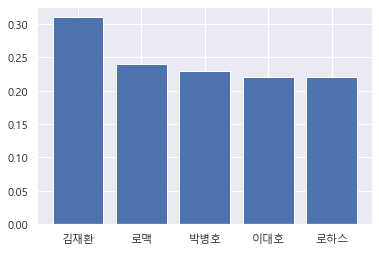

In [746]:
df_1012131415_hit = pd.concat([df_10121314_hit, df_2015_hit])
df_2018_hit = pd.read_excel('2018_타자.xlsx', index_col=0)

y = df_1012131415_hit[25]
x = df_1012131415_hit.drop([24,25], axis=1)
y1 = df_2018_hit[25]
x1 = df_2018_hit.drop([24,25], axis=1)

trr = RandomForestClassifier().fit(x, y)
preds = trr.predict_proba(x1)
list1 = preds[:,1]

df_2018_hit_c = df_2018_hit.copy()
df_2018_hit_c[26] = list1
df_2018_hit_c2 = df_2018_hit_c[[24,26]].sort_values(26, ascending=False)[:5]#.plot(kind='bar')
plt.bar(df_2018_hit_c2[24], df_2018_hit_c2[26], data = df_2018_hit_c2)
df_2018_hit_c2

In [747]:
# From https://www.kaggle.com/arthurtok/interactive-porto-insights-a-plot-ly-tutorial
# Scatter plot 
trace = go.Scatter(
    y = trr.feature_importances_,
    x = features,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 13,
        #size= rf.feature_importances_,
        #color = np.random.randn(500), #set color equal to a variable
        color = trr.feature_importances_,
        colorscale='Portland',
        showscale=True
    ),
    text = features
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Random Forest Feature Importance',
    hovermode= 'closest',
     xaxis= dict(
         ticklen= 5,
         showgrid=False,
        zeroline=False,
        showline=False
     ),
    yaxis=dict(
        title= 'Feature Importance',
        showgrid=False,
        zeroline=False,
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='kbo')

In [ ]:
#df_2019_hit.columns = ['player_team', 'player_AVG','player_G', 'player_PA',
#        'player_AB', 'player_R', 'player_H','player_2B', 'player_3B',
#         'player_HR','player_TB', 'player_RBI','player_SB', 'player_CS',
#        'player_BB', 'player_HBP', 'player_SO','player_GDP', 'player_SLG'
#       , 'player_OBP', 'player_E', 'player_name', 'mvp']
      

## 투수

,22,24
19,니퍼트,0.24
94,보우덴,0.20
104,헥터,0.11
188,양현종,0.04
51,해커,0.02


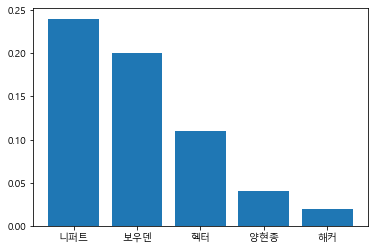

In [466]:
df_2011_pit = pd.read_excel('2011_투수.xlsx', index_col=0)
df_2016_pit = pd.read_excel('2016_투수.xlsx', index_col=0)

y = df_2011_pit[23]
x = df_2011_pit.drop([22,23], axis=1)
y1 = df_2016_pit[23]
x1 = df_2016_pit.drop([22,23], axis=1)

trr = RandomForestClassifier().fit(x, y)
preds = trr.predict_proba(x1)
list1 = preds[:,1]

df_2016_pit_c = df_2016_pit.copy()
df_2016_pit_c[24] = list1
df_2016_pit_c2 = df_2016_pit_c[[22,24]].sort_values(24, ascending=False)[:5]#.plot(kind='bar')
plt.bar(df_2016_pit_c2[22], df_2016_pit_c2[24], data = df_2016_pit_c2)
df_2016_pit_c2

,22,24
180,양현종,0.26
91,헥터,0.26
81,켈리,0.11
166,차우찬,0.02
40,임기영,0.02


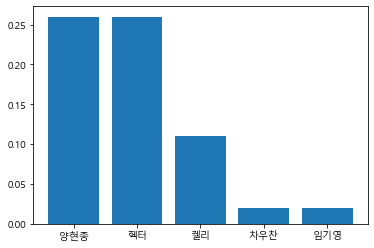

In [588]:
df_1116_pit = pd.concat([df_2011_pit, df_2016_pit])
df_2017_pit = pd.read_excel('2017_투수.xlsx', index_col=0)

y = df_1116_pit[23]
x = df_1116_pit.drop([22,23], axis=1)
y1 = df_2017_pit[23]
x1 = df_2017_pit.drop([22,23], axis=1)

trr = RandomForestClassifier().fit(x, y)
preds = trr.predict_proba(x1)
list1 = preds[:,1]

df_2017_pit_c = df_2017_pit.copy()
df_2017_pit_c[24] = list1
df_2017_pit_c2 = df_2017_pit_c[[22,24]].sort_values(24, ascending=False)[:5]#.plot(kind='bar')
plt.bar(df_2017_pit_c2[22], df_2017_pit_c2[24], data = df_2017_pit_c2)
df_2017_pit_c2

,22,24
74,린드블럼,0.56
189,김광현,0.31
120,산체스,0.17
86,이영하,0.17
188,양현종,0.08


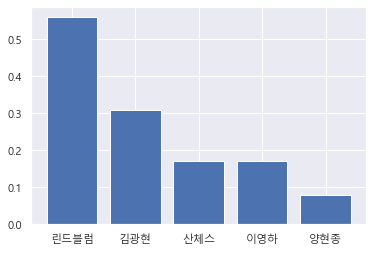

In [743]:
df_111617_pit = pd.concat([df_1116_pit, df_2017_pit])
df_2019_pit = pd.read_excel('2019_투수.xlsx', index_col=0)

y = df_111617_pit[23]
x = df_111617_pit.drop([22,23], axis=1)
y1 = df_2019_pit[23]
x1 = df_2019_pit.drop([22,23], axis=1)

trr = RandomForestClassifier().fit(x, y)
preds = trr.predict_proba(x1)
list1 = preds[:,1]

df_2019_pit_c = df_2019_pit.copy()
df_2019_pit_c[24] = list1
df_2019_pit_c2 = df_2019_pit_c[[22,24]].sort_values(24, ascending=False)[:5]#.plot(kind='bar')
plt.bar(df_2019_pit_c2[22], df_2019_pit_c2[24], data = df_2019_pit_c2)
df_2019_pit_c2

In [737]:
trr = DecisionTreeClassifier().fit(x,y)
preds = trr.predict(x1)

print('score(x1, y1) : ',trr.score(x1,y1),'\n')

from sklearn.metrics import classification_report
print(classification_report(y1, preds))

score(x1, y1) :  0.9855769230769231 

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       207
           1       0.25      1.00      0.40         1

    accuracy                           0.99       208
   macro avg       0.62      0.99      0.70       208
weighted avg       1.00      0.99      0.99       208



In [738]:
df_11161719_pit = pd.concat([df_111617_pit, df_2019_pit])
df_11161719_pit.to_excel('2010-2019_투수.xlsx')

In [740]:
df_101213141518_hit = pd.concat([df_1012131415_hit, df_2018_hit])
df_101213141518_hit.to_excel('2010-2019_타자.xlsx')

In [744]:
# From https://www.kaggle.com/arthurtok/interactive-porto-insights-a-plot-ly-tutorial
# Scatter plot 
trace = go.Scatter(
    y = trr.feature_importances_,
    x = features,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 13,
        #size= rf.feature_importances_,
        #color = np.random.randn(500), #set color equal to a variable
        color = trr.feature_importances_,
        colorscale='Portland',
        showscale=True
    ),
    text = features
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Random Forest Feature Importance',
    hovermode= 'closest',
     xaxis= dict(
         ticklen= 5,
         showgrid=False,
        zeroline=False,
        showline=False
     ),
    yaxis=dict(
        title= 'Feature Importance',
        showgrid=False,
        zeroline=False,
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='kbo')

In [ ]:
#df_2019_pit.columns = ['player_team', 'player_ERA', 'player_G', 'player_CG', '
#        player_SHO', player_W', 'player_L', 'player_SV', 'player_HLD',
#       'player_WPCT',player_TBF', 'player_IP', 'player_H', 'player_HR'
#       'player_BB', player_HBP', 'player_SO', 'player_R', 'player_ER',
#        player_name', 'mvp']

In [745]:
x, y = (list(x) for x in zip(*sorted(zip(trr.feature_importances_, features), 
                                                            reverse = False)))
trace2 = go.Bar(
    x=x ,
    y=y,
    marker=dict(
        color=x,
        colorscale = 'Viridis',
        reversescale = True
    ),
    name='Random Forest Feature importance',
    orientation='h',
)

layout = dict(
    title='Barplot of Feature importances',
     width = 900, height = 500,
    yaxis=dict(
        showgrid=False,
        showline=False,
        showticklabels=True,
#         domain=[0, 0.85],
    ))

fig1 = go.Figure(data=[trace2])
fig1['layout'].update(layout)
py.iplot(fig1, filename='plots')